# Prepare the data for run the inferences in NOMAD

In [1]:
import pandas as pd
from tf_chpvk_pv.config import PROCESSED_DATA_DIR, FIGURES_DIR

df = pd.read_csv(PROCESSED_DATA_DIR / 'stable_compositions.csv')
df.rename(columns={'Unnamed: 0': 'composition'}, inplace=True)
df['num_formula_units_per_cell'] = 4
df['space_group'] = ''

final_df = df[['composition', 'num_formula_units_per_cell', 'space_group']]


final_df.to_csv(PROCESSED_DATA_DIR / 'stable_compositions_for_CrystaLLM.csv', index=False)

2026-02-20 09:48:58.267 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


Then this the file 'stable_compositions_for_CrystaLLM.csv' can be uploaded in [nomad](https://nomad-lab.eu/prod/v1/oasis/gui/user/uploads/upload/id/rAGhkvDaTgyQPb_k3NcFbg)

# Analyze the inferences made in NOMAD

In [2]:
import json
import os
from tf_chpvk_pv.config import CRYSTALLM_DATA_DIR

# Replace with the path to your directory containing JSON files
directory_path = CRYSTALLM_DATA_DIR / 'json_files'

json_data = {}

for filename in os.listdir(directory_path):
    if filename.endswith('.json'):
        filepath = os.path.join(directory_path, filename)
        with open(filepath, 'r') as f:
            try:
                data = json.load(f)
                json_data[ filename + '_' + filename] = data
            except json.JSONDecodeError:
                print(f"Error decoding JSON from file: {filename}")

In [3]:
import pandas as pd
from tf_chpvk_pv.config import CRYSTALLM_DATA_DIR

results = pd.DataFrame(index=range(0, len(json_data.keys())),
                       columns=['material', 'atoms',
                                'a', 'b', 'c', 'alpha', 'beta', 'gamma',
                                'volume', 'atomic_density', 'mass_density'])
for idx, key in enumerate(json_data.keys()):
  try:
    chemical_formula_iupac = json_data[key]['archive']['results']['material']['topology'][0]['chemical_formula_iupac']
  except:
    print(key)
    print(json_data[key]['archive'])
    continue
  atoms_data = json_data[key]['archive']['results']['material']['topology'][0]['atoms']
  # Convert the 'atoms' dictionary to a string representation
  atoms_string = str(atoms_data)
  results.loc[idx, 'material'] = chemical_formula_iupac
  results.loc[idx, 'atoms'] = atoms_string
  for col in json_data[key]['archive']['results']['material']['topology'][0]['cell']:
    if col in ['a', 'b', 'c']:
      results.loc[idx, col] = json_data[key]['archive']['results']['material']['topology'][0]['cell'][col] * 10**10 #Amstrongs
    elif col in ['volume']:
      results.loc[idx, col] = json_data[key]['archive']['results']['material']['topology'][0]['cell'][col] * 10**30 #Amstrongs cubed
    elif col in ['atomic_density']:
      results.loc[idx, col] = json_data[key]['archive']['results']['material']['topology'][0]['cell'][col] * 10**-30 #1/Amstrons cubed
    elif col in ['alpha', 'beta', 'gamma']:
      results.loc[idx, col] = json_data[key]['archive']['results']['material']['topology'][0]['cell'][col] * 180 / 3.141592653589793 #degrees
    elif col in ['mass_density']:
      results.loc[idx, col] = json_data[key]['archive']['results']['material']['topology'][0]['cell'][col] / 1000 #g/cm3
    else:
      results.loc[idx, col] = json_data[key]['archive']['results']['material']['topology'][0]['cell'][col]


results.to_csv(CRYSTALLM_DATA_DIR / 'results_crystallm.csv')

In [4]:
results.head()

,material,atoms,a,b,c,alpha,beta,gamma,volume,atomic_density,mass_density
0,TbZnS3,{'m_def': 'nomad.datamodel.metainfo.system.Ato...,7.1784,8.7559,6.3013,90.0,90.0,90.0,396.05783,0.050498,5.375006
1,SrUSe3,{'m_def': 'nomad.datamodel.metainfo.system.Ato...,8.0312,10.4242,7.0155,90.0,90.0,90.0,587.329487,0.034052,6.361685
2,UCeSe3,{'m_def': 'nomad.datamodel.metainfo.system.Ato...,8.3754,10.4925,6.2499,90.0,90.0,90.0,549.23424,0.036414,7.437795
3,AlSnSe3,{'m_def': 'nomad.datamodel.metainfo.system.Ato...,6.9309,10.3087,7.2282,90.0,90.0,90.0,516.444545,0.038726,4.920373
4,TbEuS3,{'m_def': 'nomad.datamodel.metainfo.system.Ato...,7.6155,9.2152,6.4995,90.0,90.0,90.0,456.124222,0.043848,5.92803


# Validation with ICSD data

In [5]:
import os
from pymatgen.core import Structure
import pandas as pd

ICSD_files = '/home/dagar/TF-ChPVK-PV/data/crystaLLM/ICSD_files'

icsd_data = []
for filename in os.listdir(ICSD_files):
    if filename.endswith('.cif'):
        filepath = os.path.join(ICSD_files, filename)
        try:
            struct = Structure.from_file(filepath)
            icsd_data.append({
                'filename': filename,
                'formula': struct.composition.reduced_formula,
                'formula_pretty': struct.composition.alphabetical_formula,
                'a': struct.lattice.a,
                'b': struct.lattice.b,
                'c': struct.lattice.c,
                'alpha': struct.lattice.alpha,
                'beta': struct.lattice.beta,
                'gamma': struct.lattice.gamma,
                'volume': struct.volume,
                'space_group': struct.get_space_group_info()[0],
                'num_sites': len(struct)
            })
        except Exception as e:
            print(f"Error reading {filename}: {e}")

icsd_df = pd.DataFrame(icsd_data)
icsd_df.drop(columns=['filename']).to_csv(CRYSTALLM_DATA_DIR / 'icsd_ref_data.csv', index=False)

In [6]:
icsd_df

,filename,formula,formula_pretty,a,b,c,alpha,beta,gamma,volume,space_group,num_sites
0,EntryWithCollCode649276.cif,PrScS3,Pr4 S12 Sc4,7.1100,6.4900,9.5300,90.0,90.0,90.0,439.751367,Pna2_1,20
1,EntryWithCollCode23294.cif,CeScS3,Ce4 S12 Sc4,7.1618,9.5621,6.5065,90.0,90.0,90.0,445.577143,Pnma,20
2,EntryWithCollCode173844.cif,GdScS3,Gd4 S12 Sc4,7.0361,9.4574,6.3833,90.0,90.0,90.0,424.765286,Pnma,20
3,EntryWithCollCode650846.cif,TbScS3,S12 Sc4 Tb4,7.0300,6.3700,9.4800,90.0,90.0,90.0,424.524828,Pna2_1,20
4,EntryWithCollCode615918.cif,BaHfS3,Ba4 Hf4 S12,7.0020,9.9150,6.9950,90.0,90.0,90.0,485.626686,Pnma,20
5,EntryWithCollCode631329.cif,EuHfS3,Eu4 Hf4 S12,7.0570,9.6780,6.6610,90.0,90.0,90.0,454.930620,Pnma,20
6,EntryWithCollCode23288.cif,BaZrS3,Ba4 S12 Zr4,7.0599,9.9813,7.0251,90.0,90.0,90.0,495.037580,Pnma,20
7,EntryWithCollCode641844.cif,LaScS3,La4 S12 Sc4,7.1800,6.5300,9.6000,90.0,90.0,90.0,450.099840,Pna2_1,20
8,EntryWithCollCode631644.cif,EuZrS3,Eu4 S12 Zr4,7.1070,9.7190,6.6710,90.0,90.0,90.0,460.785536,Pnma,20
9,EntryWithCollCode650844.cif,SmScS3,S12 Sc4 Sm4,7.0700,6.4300,9.5000,90.0,90.0,90.0,431.870950,Pna2_1,20


In [7]:
from pymatgen.core import Structure, Lattice
from pymatgen.analysis.structure_matcher import StructureMatcher


cif_files_dict = CRYSTALLM_DATA_DIR / 'cif_files'

# Store comparison data for plotting
comparison_data = []

for idx, formula in enumerate(icsd_df['formula']):
    cif_file = cif_files_dict / f"{formula}_1.cif"
    cif_file_ref = ICSD_files + "/" + icsd_df.loc[idx, 'filename']

    struct1 = Structure.from_file(cif_file)
    struct2 = Structure.from_file(cif_file_ref)

    # Compare structures
    
    # Get space groups
    sg1 = struct1.get_space_group_info()[0]
    sg2 = struct2.get_space_group_info()[0]
    
    # Calculate percent differences for lattice params
    delta_a = abs(struct1.lattice.a - struct2.lattice.a) / struct2.lattice.a * 100
    delta_b = abs(struct1.lattice.b - struct2.lattice.b) / struct2.lattice.b * 100
    delta_c = abs(struct1.lattice.c - struct2.lattice.c) / struct2.lattice.c * 100
    delta_v = abs(struct1.volume - struct2.volume) / struct2.volume * 100

    # Permute the b,c lattice parameters to check for better match
    if delta_b > 20 and delta_c > 20:  # If both b and c are significantly different
        # Create a new lattice with b and c swapped
        old_lattice = struct1.lattice
        new_lattice = Lattice.from_parameters(
            a=old_lattice.a,
            b=old_lattice.c,  # swap b and c
            c=old_lattice.b,  # swap b and c
            alpha=old_lattice.alpha,
            beta=old_lattice.gamma,  # swap beta and gamma
            gamma=old_lattice.beta   # swap beta and gamma
        )
        
        # Create new structure with permuted lattice
        struct1_permuted = Structure(
            new_lattice,
            struct1.species,
            struct1.frac_coords
        )

        # Recalculate deltas using the PERMUTED structure
        delta_a_p = abs(struct1_permuted.lattice.a - struct2.lattice.a) / struct2.lattice.a * 100
        delta_b_p = abs(struct1_permuted.lattice.b - struct2.lattice.b) / struct2.lattice.b * 100
        delta_c_p = abs(struct1_permuted.lattice.c - struct2.lattice.c) / struct2.lattice.c * 100
        delta_v_p = abs(struct1_permuted.volume - struct2.volume) / struct2.volume * 100

        if delta_b_p < delta_b:  # If permutation gives better match
            struct1 = struct1_permuted
            delta_a, delta_b, delta_c, delta_v = delta_a_p, delta_b_p, delta_c_p, delta_v_p
            sg1 = struct1.get_space_group_info()[0]

    # Store data for plotting
    comparison_data.append({
        'formula': formula,
        'crystallm_a': struct1.lattice.a,
        'crystallm_b': struct1.lattice.b,
        'crystallm_c': struct1.lattice.c,
        'crystallm_alpha': struct1.lattice.alpha,
        'crystallm_beta': struct1.lattice.beta,
        'crystallm_gamma': struct1.lattice.gamma,
        'crystallm_volume': struct1.volume,
        'crystallm_sg': sg1,
        'icsd_a': struct2.lattice.a,
        'icsd_b': struct2.lattice.b,
        'icsd_c': struct2.lattice.c,
        'icsd_alpha': struct2.lattice.alpha,
        'icsd_beta': struct2.lattice.beta,
        'icsd_gamma': struct2.lattice.gamma,
        'icsd_volume': struct2.volume,
        'icsd_sg': sg2,
        'delta_a': delta_a,
        'delta_b': delta_b,
        'delta_c': delta_c,
        'delta_v': delta_v
    })
    
    # Print lattice parameters
    print(f"Comparing {formula}:")
    print(f"  CrystaLLM: a={struct1.lattice.a:.4f}, b={struct1.lattice.b:.4f}, c={struct1.lattice.c:.4f}")
    print(f"            alpha={struct1.lattice.alpha:.2f}, beta={struct1.lattice.beta:.2f}, gamma={struct1.lattice.gamma:.2f}")
    print(f"            Space group: {sg1}, Num sites: {len(struct1)}")
    print(f"  ICSD:      a={struct2.lattice.a:.4f}, b={struct2.lattice.b:.4f}, c={struct2.lattice.c:.4f}")
    print(f"            alpha={struct2.lattice.alpha:.2f}, beta={struct2.lattice.beta:.2f}, gamma={struct2.lattice.gamma:.2f}")
    print(f"            Space group: {sg2}, Num sites: {len(struct2)}")
    print(f"  Δa={delta_a:.3f}%, Δb={delta_b:.3f}%, Δc={delta_c:.3f}%, ΔV={delta_v:.3f}%")

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

Comparing PrScS3:
  CrystaLLM: a=7.2313, b=6.5144, c=9.6576
            alpha=90.00, beta=90.00, gamma=90.00
            Space group: Pnma, Num sites: 20
  ICSD:      a=7.1100, b=6.4900, c=9.5300
            alpha=90.00, beta=90.00, gamma=90.00
            Space group: Pna2_1, Num sites: 20
  Δa=1.706%, Δb=0.376%, Δc=1.339%, ΔV=3.455%
Comparing CeScS3:
  CrystaLLM: a=7.2673, b=9.5785, c=6.5061
            alpha=90.00, beta=90.00, gamma=90.00
            Space group: Pnma, Num sites: 20
  ICSD:      a=7.1618, b=9.5621, c=6.5065
            alpha=90.00, beta=90.00, gamma=90.00
            Space group: Pnma, Num sites: 20
  Δa=1.473%, Δb=0.172%, Δc=0.006%, ΔV=1.641%
Comparing GdScS3:
  CrystaLLM: a=6.9914, b=9.5392, c=6.3600
            alpha=90.00, beta=90.00, gamma=90.00
            Space group: Pna2_1, Num sites: 20
  ICSD:      a=7.0361, b=9.4574, c=6.3833
            alpha=90.00, beta=90.00, gamma=90.00
            Space group: Pnma, Num sites: 20
  Δa=0.635%, Δb=0.865%, Δc=0.365%, Δ

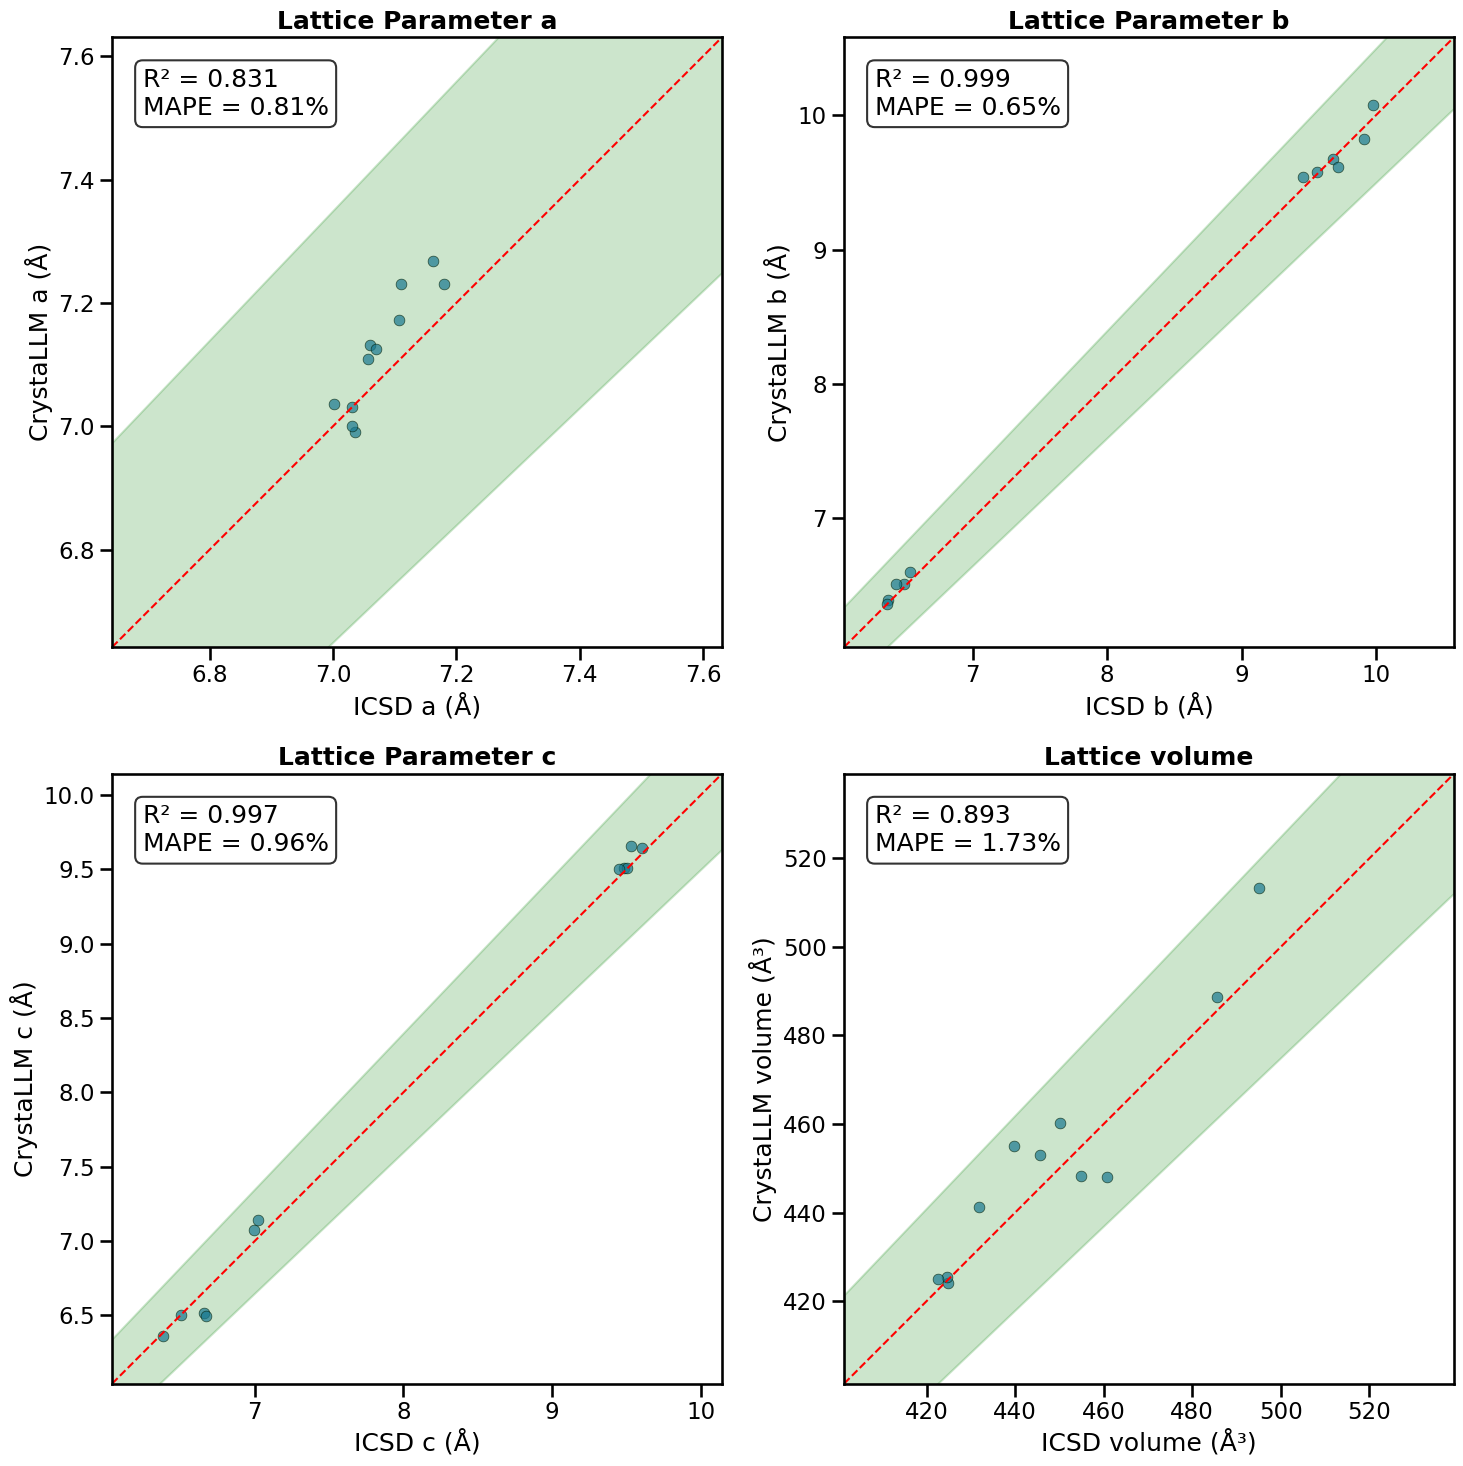

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context('talk')


fig, axes = plt.subplots(2, 2, figsize=(15, 15))

params = [('a', 'Å', 'delta_a'), ('b', 'Å', 'delta_b'), ('c', 'Å', 'delta_c'), ('volume', 'Å³', 'delta_v')]

for ax, (param, unit, delta_col) in zip(axes.flatten(), params):
    icsd_vals = comparison_df[f'icsd_{param}']
    crystallm_vals = comparison_df[f'crystallm_{param}']
    
    # Scatter plot
    ax.scatter(icsd_vals, crystallm_vals, s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Add y=x line
    min_val = min(icsd_vals.min(), crystallm_vals.min()) * 0.95
    max_val = max(icsd_vals.max(), crystallm_vals.max()) * 1.05
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5, label='y = x')
    
    # Add ±5% bands
    x_line = np.linspace(min_val, max_val, 100)
    ax.fill_between(x_line, x_line * 0.95, x_line * 1.05, alpha=0.2, color='green', label='±5%')
    
    # Labels
    ax.set_xlabel(f'ICSD {param} ({unit})')
    ax.set_ylabel(f'CrystaLLM {param} ({unit})')
    if param == 'volume':
        ax.set_title(f'Lattice {param}', fontweight='bold')
    else:
        ax.set_title(f'Lattice Parameter {param}', fontweight='bold')
    
    # Calculate R² and MAPE
    correlation = np.corrcoef(icsd_vals, crystallm_vals)[0, 1]
    r_squared = correlation ** 2


    #MAPE = Mean average percentage error
    mape = np.mean(comparison_df[delta_col])
    
    # Add stats text
    ax.text(0.05, 0.95, f'R² = {r_squared:.3f}\nMAPE = {mape:.2f}%', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'parity_plots_crystallm_vs_icsd.png', dpi=300, bbox_inches='tight')
plt.show()